# UNCERTAINTY QUANTIFICATION AND INVERSE HESSIAN APPROXIMATION USING CG #

Now our goal is to compute the invert matrix $\mathbf{\Gamma_{post}}$ without explicitely storing the matrix itself. In Bryan's thesis, an approximation of the inverse Hessian is used in that:

$$
\mathbf{\Gamma_{appox}} = \mathbf{P}(\mathbf{D})^{-1}\mathbf{P}^{T} + \sigma_{prior}^{2}(\mathbf{I} - \mathbf{V}\mathbf{V}^{T})
$$

in which $\mathbf{P}$ and $\mathbf{V}$ are the search directions and the residual vectors collected at each iteration when using CG to solve the above problem. $\mathbf{D}$ is computed by having $\mathbf{P}^{T}\mathbf{A}\mathbf{P} = \mathbf{P}^{T}\mathbf{M} = \mathbf{D}$. 

We will first try and compute the *exact* solution of the inverse Hessian, and then compared it with the approximation one.

In [1]:
%%capture
# For the sake of brevity, let's run the other notebook on here
import io
from IPython.nbformat import current

def execute_notebook(nbfile):
    
    with io.open(nbfile) as f:
        nb = current.read(f, 'json')
    
    ip = get_ipython()
    
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)

# Now run the other notebook
execute_notebook("MembraneInverseUQ.ipynb")

In [2]:
def cg_1(A, b):
    "Conjugate gradient solver"

    # Initial guess (zero vector)
    x0 = np.zeros(A.shape[1])

    # Convergence tolerance to exit solver
    tolerance = 1.0e-9

    # Create starting vectors
    r0 = b - A.dot(x0)
    r0_norm = np.linalg.norm(r0)
    p0 = r0.copy()
    
    # Now let's throw these vectors into our matrices
    # First iteration, create copies
    V = r0.copy()
    P = p0.copy()

    # Start iterations    
    for k in range(200):
        alpha = r0.dot(r0)/(p0.dot(A.dot(p0)))
        x1 = x0 + alpha*p0
        r1 = r0 - alpha*A.dot(p0)
        
        r_norm = np.linalg.norm(r1) 
        if r_norm < tolerance:
            break

        beta = r1.dot(r1)/r0.dot(r0)
        p1 = r1 + beta*p0    
        
        # Let's store the solution in some form of matrices
        V = np.vstack((V, r1))
        P = np.vstack((P, p1))
        
        # Update for next step
        p0, r0, x0 = p1, r1, x1
        
#         print k, "\n", p0, "\n", r0, "\n", r_norm
    
    print k
    return V, P, x1

In [3]:
def sum_vec(vec, Mat1, Mat2):
    results = np.zeros(vec.size)
    if Mat1.ndim == 1:
        results += ((1.0*(vec.dot(Mat1)))/(1.0*(Mat1.dot(Mat2))))*Mat2
    else:
        k = Mat1.shape[0]
        for i in range(k):
            results += ((1.0*(vec.dot(Mat1[i])))/(1.0*(Mat1[i].dot(Mat2[i]))))*Mat2[i]
    
    return results

In [4]:
def cg_2(M, b, x0):
    "Conjugate gradient solver"

    
    # Initial guess (zero vector)
    x0 = (-0.5)*np.ones(M.shape[1])

    # Convergence tolerance to exit solver
    tolerance = 1.0e-9

    # Create starting vectors
    r0 = b - M.dot(x0)
    r0_norm = np.linalg.norm(r0)
    p0 = r0.copy()
    a = M.dot(p0)
    
    # Now let's throw these vectors into our matrices
    # First iteration, create copies
    V = r0.copy()
    P = p0.copy()
    A = a.copy()

    # Start iterations    
    for k in range(200):
        alpha = r0.dot(r0)/(p0.dot(M.dot(p0)))
        x1 = x0 + alpha*p0
        r1 = r0 - alpha*M.dot(p0)
        
        r_norm = np.linalg.norm(r1) 
        if r_norm < tolerance:
            break

        beta = r1.dot(r1)/r0.dot(r0)
        p1 = r1 + beta*p0    
        a = M.dot(p1)
        
        # Let's store the solution in some form of matrices
        V = np.vstack((V, r1 ))
        P = np.vstack((P, p1 ))
        A = np.vstack((A, a))
        
        # Update for next step
        p0, r0, x0 = p1, r1, x1
        
#         print k, "\n", p0, "\n", r0, "\n", r_norm
    
    print k
    return V, P, A, x1

In [5]:
# def cg_2(Q, c):
#     "Conjugate gradient solver"
#     # Initial guess (zero vector)
#     x0 = np.zeros(Q.shape[1])

#     # Convergence tolerance to exit solver
#     tolerance = 1.0e-9

#     # Create starting vectors
#     r0 = c - Q.dot(x0)
#     r0_norm = np.linalg.norm(r0)
#     p0 = r0.copy()
    
#     # Start iteration 0 
#     # 0 -> k; 1 -> k+1, 
#     alpha = r0.dot(r0)/(p0.dot(Q.dot(p0)))
#     x1 = x0 + alpha*p0
#     r1 = r0 - alpha*Q.dot(p0)
#     a = Q.dot(p0)
#     beta = r1.dot(r1)/r0.dot(r0)
#     p1 = r1 + beta*p0
    
#     # Now let's throw these vectors into our matrices
#     # First iteration, create copies
#     V = r1.copy()
#     A = a.copy()
#     P = p1.copy()
    
#     # Update for next step
# #     p0, r0, x0 = p1, r1, x1

    
#     # Break condition
#     r_norm = np.linalg.norm(r1) 
#     if r_norm > tolerance:
#         # Start from iteration 1
#         for k in range(1, 200):
#             alpha = r0.dot(r0)/(p0.dot(a))
#             x1 = x0 + alpha*p0
#             # Update residual
#             rhat1 = r0 - alpha*a
#             # And then reorthogonise
#             r1 = rhat1 - sum_vec(rhat1, V, V)

#             # Break condition
#             r_norm = np.linalg.norm(r1) 
#             if r_norm < tolerance:
#                 break

#             beta = r1.dot(r1)/r0.dot(r0)
#             # Update search direction
#             phat1 = r1 + beta*p0    
#             # And then apply re-ortho
#             ahat = (1.0/alpha)*(r1 - r0)
#             a = ahat - sum_vec(ahat, P, A) 
#             p1 = phat1 - sum_vec(phat1, A, P) 
            
#             # Let's store the solution in some form of matrices
#             V = np.vstack((V, r1))
#             P = np.vstack((P, p1))
#             A = np.vstack((A, a))
            
#             # Update for next step
#             p0, r0, x0 = p1, r1, x1
#             # print k, "\n", p0, "\n", r0, "\n", r_norm
    
#     print k, r_norm
#     return V, A, P, x1

In [6]:
V, P, A, q1 = cg_2(M_1, c_1, b_prior)

5


In [7]:
# V, A, P, q = cg_2(M_1, c_1)

In [8]:
from scipy.sparse.linalg import cg

# Now let's solve
exact_sol = cg(M_1, c_1)[0]

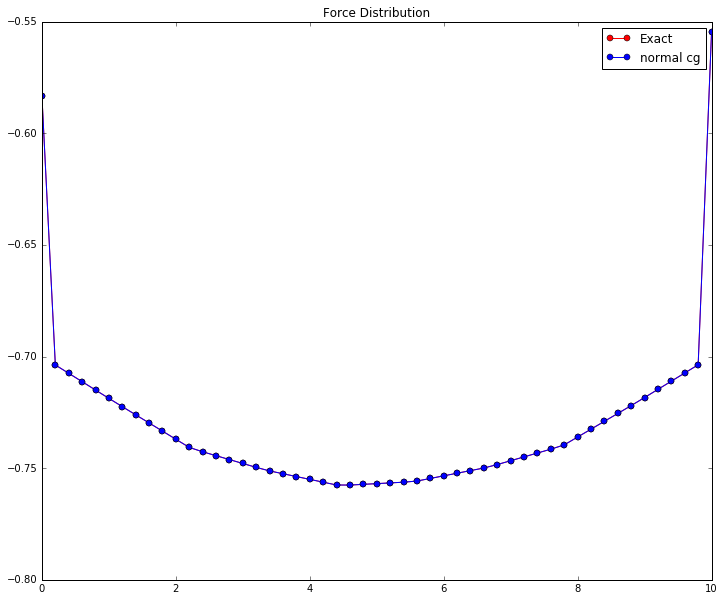

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
plt.title('Force Distribution')
plt.plot(mesh, exact_sol,'-ro', label='Exact')
# plt.plot(mesh, q,'-go', label='CG')
plt.plot(mesh, q1,'-bo', label='normal cg')
plt.legend()

# print exact_sol
# print q

Now let's look at how our Hessian inverse approximation compares to the original one. A reminder on how we compute our approximation:

$$
\mathbf{A_{appox}^{-1}} = \mathbf{P}(\mathbf{D})^{-1}\mathbf{P}^{T} + (\mathbf{I} - \sigma_{prior}^{2}\mathbf{V}\mathbf{V}^{T})
$$

in which $\mathbf{P}$ and $\mathbf{V}$ are the search directions and the residual vectors collected at each iteration when using CG to solve the above problem. $\mathbf{D}$ is computed by having $\mathbf{P}^{T}\mathbf{A} = \mathbf{D}$. 


In [21]:
# Let's get the approximation online
# print A
# print P
# print D
# print D.shape
# invD = np.linalg.inv(D.T.dot(D))

if P.ndim == 1:
    D = np.outer((1.0/P), (1.0/A))
    IH_approx = np.outer(P, (D.dot(P.T))) + np.identity(P.size) - np.outer(V, Gamma_prior.dot(V))
else:
    D = P.dot(A.T)
    invD = np.linalg.inv(D)
    print P.shape
    print invD.shape
    print np.identity(P.shape[1]) - ((h/beta_prior)**2)*(V.T.dot(V))
    IH_approx = P.T.dot(invD.dot(P)) + np.identity(P.shape[1]) - ((h/beta_prior)**2)*(V.T.dot(V))
    
print IH_approx

U_approx, s_approx, V_approx = np.linalg.svd(IH_approx, full_matrices=False)

print("Number of singular values: {}".format(len(s_approx)))
print("Max, min singular values: {}, {}".format(s_approx[0], s_approx[-1]))

(6, 51)
(6, 6)
[[ 0.98858919 -0.02535645 -0.02725589 ..., -0.02723638 -0.02534669
  -0.00745453]
 [-0.02535645  0.94335731 -0.06080789 ..., -0.06076442 -0.05662095
  -0.01656503]
 [-0.02725589 -0.06080789  0.9344811  ..., -0.06547228 -0.06078459
  -0.01780592]
 ..., 
 [-0.02723638 -0.06076442 -0.06547228 ...,  0.9345743  -0.06074113
  -0.01779317]
 [-0.02534669 -0.05662095 -0.06078459 ..., -0.06074113  0.94340078
  -0.01655866]
 [-0.00745453 -0.01656503 -0.01780592 ..., -0.01779317 -0.01655866
   0.99513005]]
[[ 1.01195176 -0.02535645 -0.02725589 ..., -0.02723638 -0.02534669
   0.00780793]
 [-0.02535645  0.95362014 -0.05316213 ..., -0.05321762 -0.0464076
  -0.01656503]
 [-0.02725589 -0.05316213  0.94045706 ..., -0.05967644 -0.05322888
  -0.01780592]
 ..., 
 [-0.02723638 -0.05321762 -0.05967644 ...,  0.94054178 -0.05310851
  -0.01779317]
 [-0.02534669 -0.0464076  -0.05322888 ..., -0.05310851  0.95365258
  -0.01655866]
 [ 0.00780793 -0.01656503 -0.01780592 ..., -0.01779317 -0.01655866
  

Comparison between Covariance Matrix


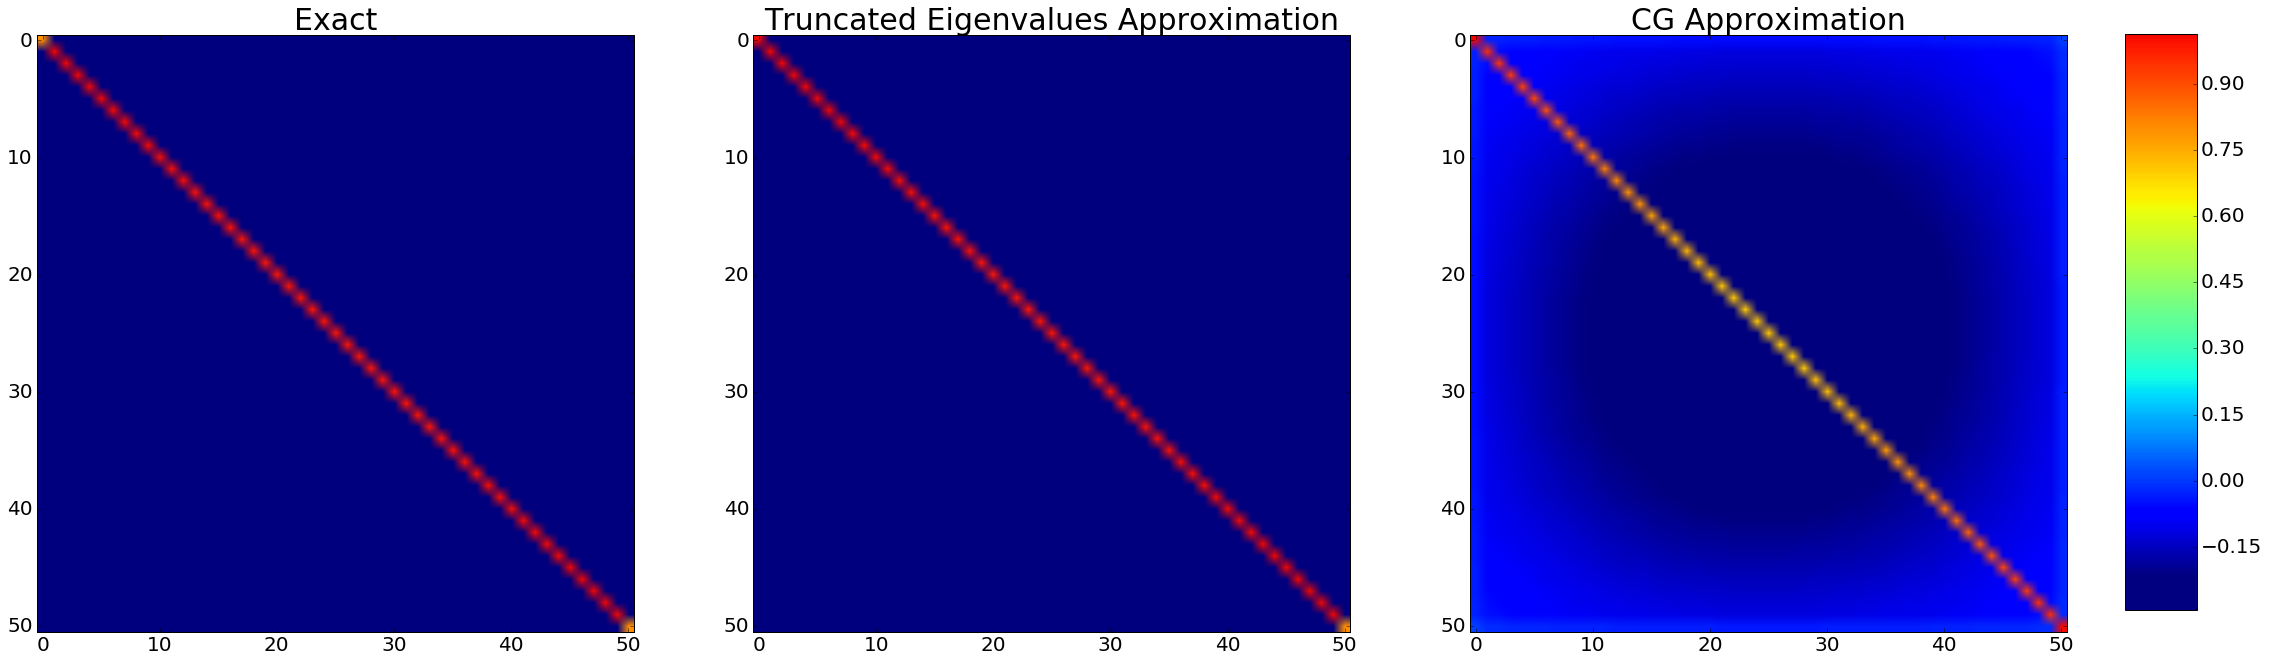

In [31]:
print "Comparison between Covariance Matrix"

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
orig_cmap = matplotlib.cm.jet
shrunk_cmap = shiftedColorMap(orig_cmap, start=-0.06, midpoint=0.45, stop=0.90, name='shrunk')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(40, 20))
ax1.set_title('Exact',  fontsize=30)
im = ax1.imshow(Gamma_post, cmap=shrunk_cmap)

ax2.set_title('Truncated Eigenvalues Approximation', fontsize=30)
im = ax2.imshow(Gamma_post_approx, cmap=shrunk_cmap)

ax3.set_title('CG Approximation',  fontsize=30)
im = ax3.imshow(IH_approx, cmap=shrunk_cmap)

fig.subplots_adjust(right=0.83)
cbar_ax = fig.add_axes([0.85, 0.32, 0.025, 0.4])
fig.colorbar(im, cax=cbar_ax)

In [12]:
# This gives the exact Hessian
# IH_exact = A_1
# U_exact, s_exact, V_exact = np.linalg.svd(IH_exact, full_matrices=False)

In [13]:
# print("Number of singular values: {}".format(len(s_exact)))
# print("Max, min singular values: {}, {}".format(s_exact[0], s_exact[-1]))

# plt.figure(figsize=(12,10))
# plt.xlabel('$i$')
# plt.ylabel('$\sigma_i$')
# plt.title('Singular values')
# plt.plot(s_exact, '-bo', label='exact');
# plt.plot(s_approx, '-go', label='approx');
# plt.legend()
# plt.yscale('log')

## REMARKS ##

1. The CG method implemented here (without reorthogonisation) will drop very quickly to an all-zeros solution as more iterations are performed. (Even faster with reorthogonisation, which I have included in the separete python file instead of implemented here.) At small number of elements - smaller number of iterations, it still performs quite OK-ish. The more iterations it has to run through, the solution will collapse to zero eventually, and hence not the right answer... (I wonder if it has anything to do with my matrix A is generated using the pseudoinverse of K...) 

2. The set of search directions and basis vectors here have not been reorthogonised at each time step. But even when added, the singular values are still way off the mark. (same with the solution...)

## QUESTIONS (TO PAUL AND GARTH) ##

1. I think I am stuck here, nothing seems to work... Where should I go from here? Should I make the code flow more smoothly and try with different prior of the data sets in stead? 

In [14]:
print beta_prior

5.0
